In [5]:
import keras

print(keras.__version__)

2.2.4


##### Enabling GPU for training the model 

In [2]:
# Import the TensorFlow library
import tensorflow as tf

# Print the number of available GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import os

# Specify the index of the GPU device to use (e.g., 0, 1)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
from tensorflow.python.client import device_lib

# Print the list of local devices
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7385391147442157623
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2960365979
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18103615450650291125
physical_device_desc: "device: 0, name: Quadro M2000M, pci bus id: 0000:01:00.0, compute capability: 5.0"
xla_global_id: 416903419
]


### Parameters of The System

####  The configuration parameters and hyperparameters used in the system. It defines variables such as image dimensions, batch size, learning rate, etc.

In [12]:
# Define the characters that can be recognized
letters = [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


# Calculate the number of classes
num_classes = len(letters) + 1

# Configuration for word recognition task
word_cfg = {
    'batch_size': 64,       # Number of samples processed in each training batch
    'input_length': 30,     # Length of the input sequence or image for the model
    'model_name': 'iam_words',  # Name or identifier for the model
    'max_text_len': 16,     # Maximum length of the recognized word
    'img_w': 128,           # Width of the input image
    'img_h': 64             # Height of the input image
}

# Configuration for line recognition task
line_cfg = {
    'batch_size': 16,       # Number of samples processed in each training batch
    'input_length': 98,     # Length of the input sequence or image for the model
    'model_name': 'iam_line',   # Name or identifier for the model
    'max_text_len': 74,     # Maximum length of the recognized line
    'img_w': 800,           # Width of the input image
    'img_h': 64             # Height of the input image
}

### Preprocessing Images

#### The functions for preprocessing the input data, such as resizing images, converting them to grayscale, normalizing pixel values, and applying any required transformations.

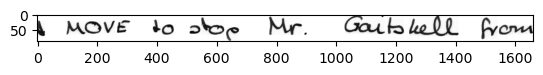

data/IAM/lines/a01/a01-000u/a01-000u-00.png
(64, 800)


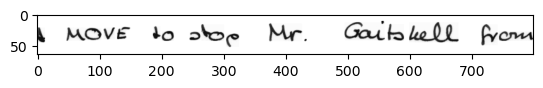

In [13]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def add_padding(img, old_w, old_h, new_w, new_h):
    # Calculate the padding values
    h1, h2 = int((new_h - old_h) / 2), int((new_h - old_h) / 2) + old_h
    w1, w2 = int((new_w - old_w) / 2), int((new_w - old_w) / 2) + old_w
    
    if len(img.shape) == 2:  # Grayscale image
        # Create a new padded image with the specified width and height, and fill it with white pixels
        img_pad = np.ones([new_h, new_w]) * 255
        # Insert the original image into the padded image at the calculated position
        img_pad[h1:h2, w1:w2] = img
    else:  # Color image
        # Create a new padded image with the specified width, height, and color channels, and fill it with white pixels
        img_pad = np.ones([new_h, new_w, 3]) * 255
        # Insert the original image into the padded image at the calculated position for each color channel
        img_pad[h1:h2, w1:w2, :] = img
    
    return img_pad
#####
'''
    img_pad = np.ones([new_h, new_w, 3]) * 255
    img_pad[h1:h2, w1:w2,:] = img
    return img_pad
'''
def fix_size(img, target_w, target_h):
    # Get the height and width of the image
    h, w = img.shape[:2]
    
    # Check if the image is smaller than the target size
    if w < target_w and h < target_h:
        # If the image is smaller, add padding to make it fit the target size
        img = add_padding(img, w, h, target_w, target_h)
    # Check if the image width is larger than or equal to the target width, but the height is smaller
    elif w >= target_w and h < target_h:
        # Calculate the new width and height to maintain the aspect ratio
        new_w = target_w
        new_h = int(h * new_w / w)
        # Resize the image using the calculated width and height
        new_img = cv.resize(img, (new_w, new_h), interpolation=cv.INTER_AREA)
        # Add padding to the resized image to make it fit the target size
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    # Check if the image height is larger than or equal to the target height, but the width is smaller
    elif w < target_w and h >= target_h:
        # Calculate the new width and height to maintain the aspect ratio
        new_h = target_h
        new_w = int(w * new_h / h)
        # Resize the image using the calculated width and height
        new_img = cv.resize(img, (new_w, new_h), interpolation=cv.INTER_AREA)
        # Add padding to the resized image to make it fit the target size
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    else:
        # If both the width and height of the image are larger than or equal to the target size
        # Calculate the resize ratio based on the larger dimension to fit the target size
        ratio = max(w / target_w, h / target_h)
        # Calculate the new width and height using the resize ratio
        new_w = max(min(target_w, int(w / ratio)), 1)
        new_h = max(min(target_h, int(h / ratio)), 1)
        # Resize the image using the calculated width and height
        new_img = cv.resize(img, (new_w, new_h), interpolation=cv.INTER_AREA)
        # Add padding to the resized image to make it fit the target size
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    
    return img

def preprocess(path, img_w, img_h):
    """ Pre-processing image for predicting """
    # Load the image as grayscale
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to load image: {path}")
    
    # Resize the image to the target width and height
    img = fix_size(img, img_w, img_h)
    
    # Clip the pixel values to the range [0, 255]
    img = np.clip(img, 0, 255)
    # Convert the pixel values to 8-bit unsigned integers
    img = np.uint8(img)
    # Convert the image to floating-point format
    img = img.astype(np.float32)
    # Normalize the pixel values to the range [0, 1]
    img /= 255
    
    print(path)
    return img

if __name__ == '__main__':
    # Load an image and display it
    img = cv.imread('data/IAM/lines/a01/a01-000u/a01-000u-00.png', 0)
    plt.imshow(img, cmap='gray')
    plt.show()
    
    # Preprocess the image and display the result
    img = preprocess('data/IAM/lines/a01/a01-000u/a01-000u-00.png', 800, 64)
    print(img.shape)
    plt.imshow(img, cmap='gray')
    plt.show()

### Image Generatoor

#### The data generator or data loading functions to efficiently load and augment the training data.

In [14]:
import numpy as np
import random
from keras import backend as K
#from Preprocessor import preprocess
#from Parameter import *

def labels_to_text(labels):
    # Convert a list of label indices to a text string using the defined mapping in the 'letters' list
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text):
    # Convert a text string to a list of label indices using the defined mapping in the 'letters' list
    return list(map(lambda x: letters.index(x), text))

class TextImageGenerator:

    def __init__(self, data, img_w, img_h, batch_size, i_len, max_text_len):
        # Initialize the TextImageGenerator object with the provided parameters
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.samples = data
        self.n = len(self.samples)
        self.i_len = i_len
        self.indexes = list(range(self.n))
        self.cur_index = 0

    def build_data(self):
        # Build the image and text data arrays
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_filepath, text) in enumerate(self.samples):
            img = preprocess(img_filepath, self.img_w, self.img_h)
            self.imgs[i, :, :] = img
            self.texts.append(text)

    def next_sample(self):
        # Get the next image and text sample in the dataset
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]

    def next_batch(self):
        while True:
            # Create arrays to hold the batch data
            if K.image_data_format() == 'channels_first':
                X_data = np.ones([self.batch_size, 1, self.img_w, self.img_h])
            else:
                X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.zeros([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * self.i_len
            label_length = np.zeros((self.batch_size, 1))

            for i in range(self.batch_size):
                # Get the next image and text sample
                img, text = self.next_sample()
                img = img.T
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i, :len(text)] = text_to_labels(text)
                label_length[i] = len(text)

            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

### CRNN (Convolutional Recurrent Neural Network) model

#### The implementation of the CRNN (Convolutional Recurrent Neural Network) model architecture.

In [3]:
#from Parameter import *
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, Reshape, Lambda, BatchNormalization
from keras.models import Model
#from keras.layers.recurrent import GRU
#from keras.layers.merge import add, concatenate

####
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import add, concatenate
####

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def word_model():
    img_w = word_cfg['img_w']
    img_h = word_cfg['img_h']
    max_text_len = word_cfg['max_text_len']
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)

    # Make Networkw
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')  # (None, 128, 64, 1)

    # Convolution layer (VGG)
    inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  # (None, 128, 64, 64)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None,64, 32, 64)

    inner = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  # (None, 64, 32, 128)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  # (None, 32, 16, 128)

    inner = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  # (None, 32, 8, 256)

    inner = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)  # (None, 32, 8, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(512, (3, 3), padding='same', name='conv6')(inner)  # (None, 32, 8, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)  # (None, 32, 4, 512)

    inner = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(inner)  # (None, 32, 4, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)

    # CNN to RNN
    inner = Reshape(target_shape=((32, 2048)), name='reshape')(inner)  # (None, 32, 2048)
    inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)  # (None, 32, 64)

    # RNN layer
    gru_1 = GRU(256, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)  # (None, 32, 512)
    gru_1b = GRU(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    reversed_gru_1b = Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (gru_1b)

    gru1_merged = add([gru_1, reversed_gru_1b])  # (None, 32, 512)
    gru1_merged = BatchNormalization()(gru1_merged)
    
    gru_2 = GRU(256, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
    reversed_gru_2b= Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (gru_2b)

    gru2_merged = concatenate([gru_2, reversed_gru_2b])  # (None, 32, 1024)
    gru2_merged = BatchNormalization()(gru2_merged)

    # transforms RNN output to character activations:
    inner = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(gru2_merged) #(None, 32, 80)
    y_pred = Activation('softmax', name='softmax')(inner)

    labels = Input(name='the_labels', shape=[max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    # loss function
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [y_pred, labels, input_length, label_length]
    )

    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    model_predict = Model(inputs=input_data, outputs=y_pred)
    model_predict.summary()


    # Convert model to JSON
    model_json = model.to_json()
    model_predict_json = model_predict.to_json()
    
    # Save JSON to file
    with open('model.json', 'w') as json_file:
        json_file.write(model_json)
    with open('model_prediction.json', 'w') as json_file:
        json_file.write(model_predict_json)
    print("JSON files created successfully.")
    return model, model_predict

### Utility Functions

#### The functions for calculating evaluation metrics, loading/saving models, visualizing results, etc

In [7]:
import os  # Import the os module for working with operating system functionality
import numpy as np  # Import the numpy library for numerical operations
import itertools  # Import the itertools module for efficient looping and iteration
#from Parameter import *  # Import the Parameter module (currently commented out)
#from Preprocessor import preprocess  # Import the preprocess function from the Preprocessor module (currently commented out)
from keras import backend as K  # Import the backend module from Keras for backend-specific operations

#This function takes the output of the model, out, and decodes it into a string by finding the index with the maximum value 
#in each row of out, grouping consecutive indices, and mapping them to characters using the letters variable
def decode_label(out):
    out_best = list(np.argmax(out[0, 2:], 1))
    out_best = [k for k, g in itertools.groupby(out_best)]
    outstr = ''
    for c in out_best:
        if c < len(letters):
            outstr += letters[c]
    return outstr

#This function takes a batch of outputs, out, and decodes each output into a string using a similar process as in decode_label(). 
#The decoded strings are stored in a list called ret.
def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret

#This function takes a partition split file and a flag indicating whether it is for words or lines. 
#It reads the partition split file and extracts the image paths and corresponding texts based on the specified flag. 
#The extracted paths and texts are stored in a list called paths_and_texts.


def get_paths_and_texts(partition_split_file, is_words):
    paths_and_texts = []
    
    with open (partition_split_file) as f:
            partition_folder = f.readlines()
    partition_folder = [x.strip() for x in partition_folder]
    
    if is_words:
        with open ('data/IAM/words.txt') as f:
            for line in f:
                if not line or line.startswith('#'): # comment in txt file
                    continue
                line_split = line.strip().split(' ')
                assert len(line_split) >= 9
                status = line_split[1]
                if status == 'err': # er: segmentation of word can be bad
                    continue

                file_name_split = line_split[0].split('-')
                label_dir = file_name_split[0]
                sub_label_dir = '{}-{}'.format(file_name_split[0], file_name_split[1])
                fn = '{}.png'.format(line_split[0])
                img_path = os.path.join('data/IAM/words', label_dir, sub_label_dir, fn)

                gt_text = ' '.join(line_split[8:])
                if len(gt_text)>16:
                    continue

                if sub_label_dir in partition_folder:
                    paths_and_texts.append([img_path, gt_text])
        
    else:
        with open('data/IAM/lines.txt') as f:
            for line in f:
                if not line or line.startswith('#'):
                    continue
                line_split = line.strip().split(' ')
                assert len(line_split) >= 9
                status = line_split[1]
                if status == 'err':
                    continue
                file_name_split = line_split[0].split('-')
                label_dir = file_name_split[0]
                sub_label_dir = '{}-{}'.format(file_name_split[0], file_name_split[1])
                fn = '{}.png'.format(line_split[0])
                img_path = os.path.join('data/IAM/lines', label_dir, sub_label_dir, fn)
                gt_text = ' '.join(line_split[8:])
                gt_text = gt_text.replace('|', ' ')
                l = len(gt_text)
                if l<10 or l>74:
                    continue
                paths_and_texts.append([img_path, gt_text])
    return paths_and_texts


def predict_image(model_predict, path, is_word):
    # Check if the prediction is for words or lines and set the width accordingly
    if is_word:
        width = word_cfg['img_w']
    else:
        width = line_cfg['img_w']
    
    # Preprocess the image using the 'preprocess' function (assumed to be defined elsewhere)
    img = preprocess(path, width, 64)
    img = img.T
    
    # Expand dimensions of the image based on the image data format
    if K.image_data_format() == 'channels_first':
        img = np.expand_dims(img, 0)
    else:
        img = np.expand_dims(img, -1)
    img = np.expand_dims(img, 0)

    # Perform the prediction using the 'model_predict' model
    net_out_value = model_predict.predict(img)
    
    # Decode the prediction into a string using the 'decode_label' function
    pred_texts = decode_label(net_out_value)
    
    return pred_texts

### Words Segmentation

#### This contain functions for segmenting the input image into individual words or lines.

In [8]:
import math
import cv2
import numpy as np


def wordSegmentation(img, kernelSize=25, sigma=11, theta=7, minArea=0):
	"""Scale space technique for word segmentation proposed by R. Manmatha: http://ciir.cs.umass.edu/pubfiles/mm-27.pdf
	
	Args:
		img: grayscale uint8 image of the text-line to be segmented.
		kernelSize: size of filter kernel, must be an odd integer.
		sigma: standard deviation of Gaussian function used for filter kernel.
		theta: approximated width/height ratio of words, filter function is distorted by this factor.
		minArea: ignore word candidates smaller than specified area.
		
	Returns:
		List of tuples. Each tuple contains the bounding box and the image of the segmented word.
	"""

	# apply filter kernel
	kernel = createKernel(kernelSize, sigma, theta)
	imgFiltered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
	(_, imgThres) = cv2.threshold(imgFiltered, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
	imgThres = 255 - imgThres

	# find connected components. OpenCV: return type differs between OpenCV2 and 3
	if cv2.__version__.startswith('3.'):
		(_, components, _) = cv2.findContours(imgThres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	else:
		(components, _) = cv2.findContours(imgThres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

	# append components to result
	res = []
	for c in components:
		# skip small word candidates
		if cv2.contourArea(c) < minArea:
			continue
		# append bounding box and image of word to result list
		currBox = cv2.boundingRect(c) # returns (x, y, w, h)
		(x, y, w, h) = currBox
		currImg = img[y:y+h, x:x+w]
		res.append((currBox, currImg))

	# return list of words, sorted by x-coordinate
	return sorted(res, key=lambda entry:entry[0][0])


#This function takes an image and a desired height as input. It first checks if the image dimensions are either 2 or 3. 
#If the image has 3 dimensions, it assumes it is in color and converts it to grayscale using cv2.cvtColor() with the COLOR_BGR2GRAY 
#conversion flag. Then, it calculates the original height of the image and computes a resizing factor by dividing the desired height 
#by the original height. Finally, it resizes the image using cv2.resize() with the computed factor and returns the resized image.

def prepareImg(img, height):
	"""convert given image to grayscale image (if needed) and resize to desired height"""
	assert img.ndim in (2, 3)
	if img.ndim == 3:
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	h = img.shape[0]
	factor = height / h
	return cv2.resize(img, dsize=None, fx=factor, fy=factor)

#This function creates an anisotropic filter kernel based on the given parameters: kernelSize, sigma, and theta. 
#It first asserts that the kernelSize is an odd number (to maintain symmetry). 
#It then calculates the halfSize as the integer division of kernelSize by 2.
#The function then iterates over each element of the kernel matrix using nested loops. For each element, 
#it calculates the displacement from the center of the kernel (i.e., x and y), and computes the exponential term, expTerm, 
#based on the displacement values. It also calculates the xTerm and yTerm terms using the displacement values and the sigma values.

def createKernel(kernelSize, sigma, theta):
	"""create anisotropic filter kernel according to given parameters"""
	assert kernelSize % 2 # must be odd size
	halfSize = kernelSize // 2
	
	kernel = np.zeros([kernelSize, kernelSize])
	sigmaX = sigma
	sigmaY = sigma * theta
	
	for i in range(kernelSize):
		for j in range(kernelSize):
			x = i - halfSize
			y = j - halfSize
			
			expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
			xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
			yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)
			
			kernel[i, j] = (xTerm + yTerm) * expTerm

	kernel = kernel / np.sum(kernel)
	return kernel

### Training The model

#### The functions for initializing the model, defining the loss function and optimizer, and running the training loop

In [13]:
#from Parameter import *
#from ImageGenerator import TextImageGenerator
#from CRNN_Model import word_model, line_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
#from Utils import *


def train(train_data, val_data, is_word_model):
    if is_word_model:
        model, _ = word_model()  # Get the word model
        cfg = word_cfg  # Get the configuration for the word model
    else:
        model, _ = line_model()  # Get the line model
        cfg = line_cfg  # Get the configuration for the line model

    input_length = cfg['input_length']  # Get the length of the input sequence
    model_name = cfg['model_name']  # Get the name of the model
    max_text_len = cfg['max_text_len']  # Get the maximum text length
    img_w = cfg['img_w']  # Get the image width
    img_h = cfg['img_h']  # Get the image height
    batch_size = cfg['batch_size']  # Get the batch size

    train_set = TextImageGenerator(train_data, img_w, img_h, batch_size, input_length, max_text_len)  # Create a TextImageGenerator for the training data
    print('Loading data for train ...')
    train_set.build_data()  # Prepare the training data for training

    val_set = TextImageGenerator(val_data, img_w, img_h, batch_size, input_length, max_text_len)  # Create a TextImageGenerator for the validation data
    val_set.build_data()  # Prepare the validation data for training
    print('Done')

    print("Number train samples: ", train_set.n)  # Print the number of training samples
    print("Number val samples: ", val_set.n)  # Print the number of validation samples

    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')  # Compile the model with CTC loss and Adam optimizer

    ckp = ModelCheckpoint(
        filepath='Resource/'+model_name+'--{epoch:02d}--{val_loss:.3f}.h5', monitor='val_loss',
        verbose=1, save_best_only=True, save_weights_only=True
    )  # Create a ModelCheckpoint callback to save the best model during training

    earlystop = EarlyStopping(
        monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
    )  # Create an EarlyStopping callback to stop training if the validation loss does not improve

    model.fit_generator(generator=train_set.next_batch(),
                        steps_per_epoch=train_set.n // batch_size,
                        epochs=32,
                        validation_data=val_set.next_batch(),
                        validation_steps=val_set.n // batch_size,
                        callbacks=[ckp, earlystop])  # Train the model using the training and validation data and the specified callbacks

    return model  # Return the trained model

In [14]:
if __name__=='__main__':
    # Get paths and texts for training data
    train_data = get_paths_and_texts('data/IAM/splits/train.uttlist', is_words=True)
    
    # Get paths and texts for validation data
    val_data = get_paths_and_texts('data/IAM/splits/validation.uttlist', is_words=True)
    
    # Print the number of training images
    print('number of train image: ', len(train_data))
    
    # Print the number of validation images
    print('number of valid image: ', len(val_data))

    # Train the model on the training data
    model = train(train_data, val_data, True)

number of train image:  47992
number of valid image:  7559
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, 128, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 64, 64)  640         ['the_input[0][0]']              
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 128, 64, 64)  256        ['conv1[0][0]']                  
 rmalization)                                                                                     
                                 

C:\Users\MC\AppData\Local\Temp\ipykernel_22380\2782514055.py:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_set.next_batch(),


749/749 [==============================] - ETA: 0s - loss: 13.5246
Epoch 1: val_loss improved from inf to 10.90540, saving model to Resource\iam_words--01--10.905.h5
749/749 [==============================] - 407s 534ms/step - loss: 13.5246 - val_loss: 10.9054
Epoch 2/32
749/749 [==============================] - ETA: 0s - loss: 7.2794
Epoch 2: val_loss improved from 10.90540 to 6.61143, saving model to Resource\iam_words--02--6.611.h5
749/749 [==============================] - 400s 535ms/step - loss: 7.2794 - val_loss: 6.6114
Epoch 3/32
749/749 [==============================] - ETA: 0s - loss: 3.9864
Epoch 3: val_loss improved from 6.61143 to 3.48687, saving model to Resource\iam_words--03--3.487.h5
749/749 [==============================] - 400s 534ms/step - loss: 3.9864 - val_loss: 3.4869
Epoch 4/32
749/749 [==============================] - ETA: 0s - loss: 2.8432
Epoch 4: val_loss improved from 3.48687 to 3.43796, saving model to Resource\iam_words--04--3.438.h5
749/749 [=========

### Evaluating Word Model

#### Evaluating the trained model on word-level

In [15]:
from sklearn.model_selection import train_test_split
import editdistance
from keras.models import model_from_json 
import tensorflow as tf
from keras.models import model_from_json
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


if __name__=='__main__':
    # Get paths and texts for test data
    test_data = get_paths_and_texts('data/IAM/splits/test.uttlist', is_words=True)
    
    # Print the number of test images
    print('number of test image: ', len(test_data))

    # Load the trained model from the saved JSON file
    with open('Resource/model_prediction.json', 'r') as f:
        model = model_from_json(f.read())
        
    # Load the weights of the trained model
    model.load_weights('Resource/iam_words--17--1.887.h5')

    # Initialize variables for evaluation
    ed_chars = num_chars = ed_words = num_words = 0
    
    # Iterate over test data
    for path, gt_text in test_data:
        # Predict the text from the image using the model
        pred_text = predict_image(model, path, is_word=True)
        
        # Check if the predicted text is different from the ground truth text
        if gt_text != pred_text:
            ed_words += 1
            
        num_words += 1
        ed_chars += editdistance.eval(gt_text, pred_text)
        num_chars += len(gt_text)

		print('ED chars: ', ed_chars)
		print('ED words: ', ed_words)

	print('CER: ', ed_chars / num_chars)
	print('WER: ', ed_words / num_words)

number of test image:  20306
data/IAM/words\c04\c04-110\c04-110-01-00.png


C:\Users\MC\Anaconda3\envs\newenv\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


ED chars:  0
ED words:  0
data/IAM/words\c04\c04-110\c04-110-01-01.png
ED chars:  0
ED words:  0
data/IAM/words\c04\c04-110\c04-110-01-02.png
ED chars:  0
ED words:  0
data/IAM/words\c04\c04-110\c04-110-01-03.png
ED chars:  0
ED words:  0
data/IAM/words\c04\c04-110\c04-110-01-04.png
ED chars:  0
ED words:  0
data/IAM/words\c04\c04-110\c04-110-01-05.png
ED chars:  0
ED words:  0
data/IAM/words\c04\c04-110\c04-110-01-06.png
ED chars:  0
ED words:  0
data/IAM/words\c04\c04-110\c04-110-01-07.png
ED chars:  0
ED words:  0
data/IAM/words\c04\c04-110\c04-110-01-08.png
ED chars:  2
ED words:  1
data/IAM/words\c04\c04-110\c04-110-01-09.png
ED chars:  3
ED words:  2
data/IAM/words\c04\c04-110\c04-110-01-10.png
ED chars:  3
ED words:  2
data/IAM/words\c04\c04-110\c04-110-01-11.png
ED chars:  3
ED words:  2
data/IAM/words\c04\c04-110\c04-110-01-12.png
ED chars:  3
ED words:  2
data/IAM/words\c04\c04-110\c04-110-01-13.png
ED chars:  3
ED words:  2
data/IAM/words\c04\c04-110\c04-110-01-14.png
ED cha

### Spell Checking

#### The functions for spell checking or post-processing the recognized text to improve its correctness.

In [16]:
import re
from collections import Counter

def words(text):
    "Tokenize text into a list of words."
    return re.findall(r'\w+', text.lower())

# Count the occurrences of each word in the text
words_count = Counter(words(open('Resource/big.txt').read()))

# Get the list of checked words
checked_word = words(open('Resource/wordlist_mono_clean.txt').read())

def P(word, N=sum(words_count.values())):
    "Probability of `word`."
    return words_count[word] / N

def correction(word):
    "Most probable spelling correction for word."
    # Check if the word is already in the checked word list
    if word.lower() in checked_word:
        new_word = word
    else:
        # Generate possible candidates for the misspelled word and select the most probable one
        new_word = max(candidates(word, words_count), key=P)
        
        # Preserve the capitalization of the first letter if it matches the original word
        if word[0].lower() == new_word[0]:
            new_word = list(new_word)
            new_word[0] = word[0]
            new_word = ''.join(new_word)
    return new_word

def correction_list(words):
    "Apply spelling correction to a list of words."
    res = []
    for word in words:
        # Check if the word is already in the checked word list
        if word.lower() in checked_word:
            new_word = word
        else:
            # Generate possible candidates for the misspelled word and select the most probable one
            new_word = max(candidates(word, words_count), key=P)
            
            # Preserve the capitalization of the first letter if it matches the original word
            if word[0].lower() == new_word[0]:
                new_word = list(new_word)
                new_word[0] = word[0]
                new_word = ''.join(new_word)
        res.append(new_word)
    return res

def candidates(word):
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words):
    "The subset of `words` that appear in the dictionary."
    return set(w for w in words if w in words_count)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters = 'abcdefghijklmnopqrstuvwxyz'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
    replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
    inserts = [L + c + R for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

if __name__ == '__main__':
    # Test the correction function
    print(correction('Smell'))

Smell


### Predicting Handwritten Images

#### The functions to perform predictions on new, unseen data using the trained model

tmp/0.png
tmp/1.png
tmp/2.png
tmp/3.png
tmp/4.png
tmp/5.png
tmp/6.png
tmp/7.png
-----------PREDICT-------------
[Word model]: len , run They maay bes inaccurate ,
[Word model with spell]: len a run They may bes inaccurate a


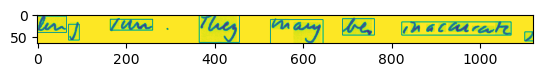

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.models import model_from_json
import shutil
from keras import backend as K
from keras.utils import plot_model

if __name__=='__main__':
	with open('Resource/model_prediction.json', 'r') as f:
		w_model_predict = model_from_json(f.read())
	#plot_model(l_model_predict, to_file='line_model.png', show_shapes=True, show_layer_names=True)
	w_model_predict.load_weights('Resource/iam_words--17--1.887.h5')
	#l_model_predict.load_weights('Resource/iam_lines--12--17.373.h5')
	test_img = 'Resource/test/6.png'
	
	img = prepareImg(cv2.imread(test_img), 64)
	img2 = img.copy()
	res = wordSegmentation(img, kernelSize=25, sigma=11, theta=7, minArea=100)
	if not os.path.exists('tmp'):
		os.mkdir('tmp')

	for (j, w) in enumerate(res):
		(wordBox, wordImg) = w
		(x, y, w, h) = wordBox
		cv2.imwrite('tmp/%d.png'%j, wordImg)
		cv2.rectangle(img2,(x,y),(x+w,y+h),(0,255,0),1) # draw bounding box in summary image

	cv2.imwrite('Resource/test/summary.png', img2)
	plt.imshow(img2)
	imgFiles = os.listdir('tmp')
	imgFiles = sorted(imgFiles)
	pred_line = []
	for f in imgFiles:
		pred_line.append(predict_image(w_model_predict, 'tmp/'+f, True))
	print('-----------PREDICT-------------')
	print('[Word model]: '+' '.join(pred_line))
	pred_line = correction_list(pred_line)
	print('[Word model with spell]: '+' '.join(pred_line))
	
	#print('[Line model]: ' + predict_image(l_model_predict, test_img, False))

	plt.show()
	shutil.rmtree('tmp')

In [ ]:
# Norvig, P. (2016, August). How to write a spelling corrector. Norvig. Retrieved February 28, 2024, from http://norvig.com/spell-correct.html